# House Prices - Advanced Regression Techniques
(Preços de casas - Técnicas Avançadas de Regressão)

<img src="https://github.com/lucaslealx/HousePrices/blob/main/img/img1.png?raw=true" width=800>


- Vamos utilizar o [dataset disponível no Kaggle](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)
    - É um dataset de **competição**
    - Temos uma base com a **descrição de cada uma das colunas (data_description.txt)**

In [1]:
# Importando o pandas
import pandas as pd

In [2]:
# Importando os datasets
treino = pd.read_csv('train.csv')
teste = pd.read_csv('test.csv')

In [3]:
# Visualizando essa base
treino.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


<a id="index"></a>
## Começando a explorar os dados
- **Index:**
    - [PoolQC, MiscFeature, Alley, Fence](#top4)
    - [FireplaceQu](#FireplaceQu)
    - [LotFrontage](#LotFrontage)
    - [colunas de Garagem](#garagem)
    - [colunas de Porão](#porao)
    - [MasVnrType, MasVnrArea, Electrical system](#restante)
    - [Analisando o restante das colunas de teste](#restante_teste)

In [4]:
# Visualizando quantidade de valores vazios
treino.isnull().sum().sort_values(ascending=False)

PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
FireplaceQu     690
               ... 
ExterQual         0
Exterior2nd       0
Exterior1st       0
RoofMatl          0
SalePrice         0
Length: 81, dtype: int64

In [5]:
# Calculando % a quantidade de valores vazios
(treino.isnull().sum()/treino.shape[0]).sort_values(ascending=False).head(10)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageCond      0.055479
GarageType      0.055479
GarageFinish    0.055479
dtype: float64

<a id='4top'></a>
- **As 4 primeiras colunas tem mais de 80% dos valores vazios na base de treino**
    - Ao invés de eliminar essas colunas, vamos entender cada um dos dados:
        - **PoolQC**: **Qualidade** da piscina
            - NA: No Pool
        - **MiscFeature**: Qualquer recurso não considerado nas outras categorias
            - NA: None
        - **Alley**: Tipo de beco / ruela para acesso a propriedade
            - NA: No alley access
        - **Fence**: **Qualidade** da cerca
            - NA: No Fence


- Nesse caso **o NA não é ausência de informação, <font color='red'>ele é uma informação</font>**


- Podemos entender melhor os dados nessas colunas e principalmente sua **relação com o preço de venda**

In [6]:
# Podemos substituir os valores vazios na primeira coluna por -1
treino[['PoolQC','MiscFeature','Alley','Fence']] = treino[['PoolQC','MiscFeature','Alley','Fence']].fillna(-1)

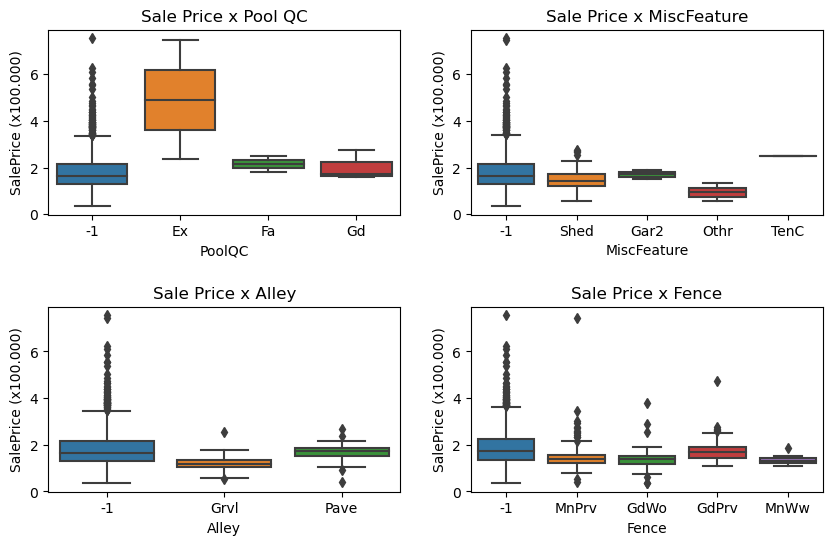

In [7]:
# Visualizando a relação com o preço
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(10,6))

sns.boxplot(x=treino.PoolQC,y=treino.SalePrice/100000,ax=ax[0,0])
ax[0,0].set_ylabel('SalePrice (x100.000)')
ax[0,0].set_title('Sale Price x Pool QC')
sns.boxplot(x=treino.MiscFeature,y=treino.SalePrice/100000,ax=ax[0,1])
ax[0,1].set_ylabel('SalePrice (x100.000)')
ax[0,1].set_title('Sale Price x MiscFeature')
sns.boxplot(x=treino.Alley,y=treino.SalePrice/100000,ax=ax[1,0])
ax[1,0].set_ylabel('SalePrice (x100.000)')
ax[1,0].set_title('Sale Price x Alley')
sns.boxplot(x=treino.Fence,y=treino.SalePrice/100000,ax=ax[1,1])
ax[1,1].set_ylabel('SalePrice (x100.000)')
ax[1,1].set_title('Sale Price x Fence')

plt.subplots_adjust(hspace=0.5)
plt.show()

- **Vamos começar a já fazer os mesmos tratamentos para a <font color='blue'>base de teste</font>** 
    - (depois vamos automatizar esse processo, mas por enquanto vamos fazer o passo a passo de cada etapa)

In [8]:
# Verificando o shape da base de treino
teste.shape

(1459, 80)

In [9]:
# Ajustando também para a base de teste
teste[['PoolQC','MiscFeature','Alley','Fence']] = teste[['PoolQC','MiscFeature','Alley','Fence']].fillna(-1)

In [10]:
# Verificando o shape da base de teste
teste.shape

(1459, 80)

<p style='text-align: right;'><a href="#index">Voltar</a></p>

<a id=FireplaceQu></a>
- **Agora analisando a coluna <font color='blue'>FireplaceQu</font>**
- Temos 2 colunas relacionadas a lareiras:
    - **Fireplaces**: Number of fireplaces
    - **FireplaceQu**: Fireplace quality

In [11]:
# Visualizando a quantidade de registros em cada rótulo
treino[['Fireplaces','FireplaceQu']].value_counts(dropna=False)

Fireplaces  FireplaceQu
0           NaN            690
1           Gd             324
            TA             259
2           Gd              54
            TA              53
1           Fa              28
            Po              20
            Ex              19
2           Ex               4
            Fa               4
3           Gd               2
            Ex               1
            Fa               1
            TA               1
dtype: int64

- Esse NaN também é uma informação, dizendo que **não existe lareira**

In [12]:
# Ajustando essa coluna
treino[['FireplaceQu']] = treino[['FireplaceQu']].fillna(-1)

- Novamente fazendo o mesmo para a **<font color='blue'>base de teste</font>**

In [13]:
# Visualizando a quantidade de registros em cada rótulo
teste[['Fireplaces','FireplaceQu']].value_counts(dropna=False)

Fireplaces  FireplaceQu
0           NaN            730
1           Gd             303
            TA             236
2           Gd              58
            TA              39
1           Fa              35
            Po              26
            Ex              18
2           Fa               6
3           Gd               3
            TA               3
2           Ex               1
4           TA               1
dtype: int64

In [14]:
# Fazendo a transformação para a base de teste
teste[['FireplaceQu']] = teste[['FireplaceQu']].fillna(-1)

- **Visualizando novamente as informações de valores vazios**

In [15]:
# Calculando % a quantidade de valores vazios
(treino.isnull().sum()/treino.shape[0]).sort_values(ascending=False).head(10)

LotFrontage     0.177397
GarageFinish    0.055479
GarageCond      0.055479
GarageYrBlt     0.055479
GarageQual      0.055479
GarageType      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtCond        0.025342
BsmtFinType1    0.025342
dtype: float64

In [16]:
# Verificando a quantidade de valores
treino.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     259
GarageFinish     81
GarageCond       81
GarageYrBlt      81
GarageQual       81
GarageType       81
BsmtFinType2     38
BsmtExposure     38
BsmtCond         37
BsmtFinType1     37
dtype: int64

<p style='text-align: right;'><a href="#index">Voltar</a></p>

<a id=LotFrontage></a>
- **<font color='blue'>LotFrontage</font>: Pés lineares (medida de distância) de rua conectados à propriedade**

In [17]:
# Entendendo os tipos de propriedades que possuem valor nulo
treino.loc[treino.LotFrontage.isnull(),'LotConfig'].value_counts()

Inside     134
Corner      62
CulDSac     49
FR2         14
Name: LotConfig, dtype: int64

In [18]:
# Verificando a média por tipo de propriedade
treino.groupby('LotConfig')['LotFrontage'].mean()

LotConfig
Corner     84.039801
CulDSac    59.911111
FR2        63.515152
FR3        70.750000
Inside     67.715686
Name: LotFrontage, dtype: float64

- Nesse caso o valor vazio **parece um erro da base**

In [19]:
# Substituindo os valores vazios pela média em relação ao LotConfig
treino['LotFrontage'] = treino['LotFrontage'].fillna(treino.groupby('LotConfig')['LotFrontage'].transform('mean'))

- Para a **<font color='blue'>base de teste</font>**

In [20]:
# Fazendo para a base de teste
teste['LotFrontage'] = teste['LotFrontage'].fillna(treino.groupby('LotConfig')['LotFrontage'].transform('mean'))

<p style='text-align: right;'><a href="#index">Voltar</a></p>

<a id="garagem"></a>
- **Avaliando as <font color='blue'>colunas de garagem</font>**
    - **GarageType**: Garage location
        - **NA: No Garage**
    - **GarageYrBlt**: Year garage was built
	- **GarageFinish**: Interior finish of the garage
        - **NA: No Garage**		
    - **GarageCars**: Size of garage in car capacity
	- **GarageArea**: Size of garage in square feet
	- **GarageQual**: Garage quality
        - **NA: No Garage**		
	- **GarageCond**: Garage condition
        - **NA: No Garage**		

In [21]:
# Verificando as colunas que possuem garagem no nome
col_garagem = treino.columns[treino.columns.str.contains("Garage")]
col_garagem

Index(['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond'],
      dtype='object')

In [22]:
# Filtrando a base
treino.loc[treino.GarageType.isnull(),col_garagem].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
NaN         NaN          NaN           0           0           NaN         NaN           81
dtype: int64

- **O NaN em todas essas colunas é que não existe garagem**

In [23]:
# Podemos selecionar apenas as colunas vazias
treino.loc[treino.GarageType.isnull(),col_garagem[[0,1,2,5,6]]].head(3)

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN


In [24]:
# Verificando os valores
treino.loc[treino.GarageType.isnull(),col_garagem[[0,1,2,5,6]]].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageQual  GarageCond
NaN         NaN          NaN           NaN         NaN           81
dtype: int64

In [25]:
# E substituir esses valores por -1
treino.loc[treino.GarageType.isnull(),col_garagem[[0,1,2,5,6]]] = -1

In [26]:
# Verificando novamente quando a quantidade de carros é igual a 0
treino.loc[treino.GarageCars == 0,col_garagem].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
-1          -1.0         -1            0           0           -1          -1            81
dtype: int64

In [27]:
# Resumindo os valores vazios da base de treino
treino.isnull().sum().sort_values(ascending=False).head(9)

BsmtExposure    38
BsmtFinType2    38
BsmtFinType1    37
BsmtQual        37
BsmtCond        37
MasVnrType       8
MasVnrArea       8
Electrical       1
FireplaceQu      0
dtype: int64

- Para a **<font color='blue'>base de teste</font>**

In [28]:
# Verificando os valores
teste.loc[teste.GarageCond.isnull(),col_garagem].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond
NaN         NaN          NaN           0.0         0.0         NaN         NaN           76
Detchd      NaN          NaN           1.0         360.0       NaN         NaN            1
                                       NaN         NaN         NaN         NaN            1
dtype: int64

- Tratando a linha onde GarageCars é zero e tudo é vazio

In [29]:
# Analisando a condição de GarageType ser nulo
teste.loc[teste.GarageType.isnull(),col_garagem[[0,1,2,5,6]]].value_counts(dropna=False)

GarageType  GarageYrBlt  GarageFinish  GarageQual  GarageCond
NaN         NaN          NaN           NaN         NaN           76
dtype: int64

In [30]:
# E substituir esses valores por -1
teste.loc[teste.GarageType.isnull(),col_garagem[[0,1,2,5,6]]] = -1

- Agora vamos entender as colunas com tudo vazio mas GarageType = "Detchd"

In [31]:
# Entendendo essas colunas
teste.loc[teste.GarageCond.isnull(),col_garagem]

,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond
666,Detchd,NaN,NaN,1.0,360.0,NaN,NaN
1116,Detchd,NaN,NaN,NaN,NaN,NaN,NaN


- Analisando a coluna GarageYrBlt

In [32]:
# Vamos verificar os valores quando GarageType == "Detchd"
teste2 = teste.loc[(teste.GarageType == 'Detchd') & (teste.GarageYrBlt != -1)]
teste2.corr()['GarageYrBlt'].sort_values(ascending=False).head(3)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_16592\747343904.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  teste2.corr()['GarageYrBlt'].sort_values(ascending=False).head(3)


GarageYrBlt    1.000000
YearBuilt      0.615951
GarageArea     0.494670
Name: GarageYrBlt, dtype: float64

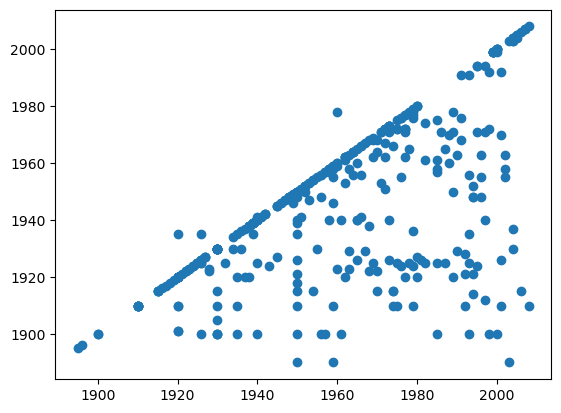

In [33]:
# Visualizando essa correlação
fig, ax = plt.subplots()

ax.scatter(teste2.GarageYrBlt,teste2.YearBuilt)

plt.show()

In [34]:
# Verificando a nova coluna
teste['CheckAnos'] = teste.GarageYrBlt == teste.YearBuilt
teste.CheckAnos.value_counts()

True     1127
False     332
Name: CheckAnos, dtype: int64

In [35]:
# Apagando essa coluna
teste = teste.drop('CheckAnos',axis=1)

In [36]:
# Verificando os valores de construção da casa
teste.loc[teste.GarageCond.isnull(),'YearBuilt']

666     1910
1116    1923
Name: YearBuilt, dtype: int64

In [37]:
# Substituindo as colunas vazias pelo ano de construção da casa
teste.loc[teste.GarageCond.isnull(),'GarageYrBlt'] = teste.loc[teste.GarageCond.isnull(),'YearBuilt']

- E a coluna GarageFinish

In [38]:
# Verificando os valores mais frequentes
teste.loc[(teste.GarageType == 'Detchd'),'GarageFinish'].value_counts()

Unf    365
RFn     15
Fin     10
Name: GarageFinish, dtype: int64

In [39]:
# Vamos verificar os valores quando GarageType == "Detchd"
moda_GarageFinish = teste.loc[(teste.GarageType == 'Detchd'),'GarageFinish'].mode()[0]
moda_GarageFinish

'Unf'

In [40]:
# Podemos substituir pelo valor mais frequente
teste.loc[(teste.GarageType == 'Detchd') & (teste.GarageFinish.isnull()),'GarageFinish'] = moda_GarageFinish

- Fazendo o mesmo para GarageQual e GarageCond

In [41]:
# Vamos verificar os valores quando GarageType == "Detchd"
teste.loc[(teste.GarageType == 'Detchd'),['GarageQual','GarageCond']].value_counts()

GarageQual  GarageCond
TA          TA            309
Fa          TA             38
            Fa             19
TA          Fa             16
Fa          Po              3
Gd          Ex              1
Po          Fa              1
            Po              1
TA          Gd              1
            Po              1
dtype: int64

In [42]:
# Podemos verificar a moda dessa coluna
moda_GarageQual = teste.loc[(teste.GarageType == 'Detchd'),'GarageQual'].mode()[0]
moda_GarageCond = teste.loc[(teste.GarageType == 'Detchd'),'GarageCond'].mode()[0]
print(moda_GarageQual,moda_GarageCond)

TA TA


In [43]:
# E usar esse valor no GarageQual
teste.loc[(teste.GarageType == 'Detchd') & (teste.GarageQual.isnull()),'GarageQual'] = moda_GarageQual

In [44]:
# E fazer o mesmo para GarageCond
teste.loc[(teste.GarageType == 'Detchd') & (teste.GarageCond.isnull()),'GarageCond'] = moda_GarageCond

- Para finalizar as colunas de garagem, vamos tratar GarageCars e GarageArea

In [45]:
# Agora vamos visualizar a média desses valores quando GarageType == "Detchd"
media_carros = teste.loc[(teste.GarageType == 'Detchd'),['GarageCars','GarageArea']].mean()
media_carros

GarageCars      1.519182
GarageArea    412.202046
dtype: float64

In [46]:
# Como Não podemos ter meio carro, vamos arredondar os valores
media_carros = round(media_carros,0)
media_carros.values

array([  2., 412.])

In [47]:
# Podemos usar esses valores se a média for vazia
teste.loc[(teste.GarageType == 'Detchd'),['GarageCars','GarageArea']] = media_carros.values

In [48]:
# Visualizando os tratamentos feitos
teste.iloc[[666,1116],55:70]

,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch
666,Typ,0,-1,Detchd,1910.0,Unf,2.0,412.0,TA,TA,Y,64,0,180,0
1116,Typ,0,-1,Detchd,1923.0,Unf,2.0,412.0,TA,TA,Y,174,0,212,0


In [49]:
# Resumindo os valores vazios da base de teste
teste.isnull().sum().sort_values(ascending=False).head(10)

BsmtCond        45
BsmtQual        44
BsmtExposure    44
BsmtFinType1    42
BsmtFinType2    42
MasVnrType      16
MasVnrArea      15
MSZoning         4
BsmtFullBath     2
Utilities        2
dtype: int64

<p style='text-align: right;'><a href="#index">Voltar</a></p>

<a id="porao"></a>
- **E fazendo a mesma coisa para as <font color='blue'>colunas de Porão</font>**
    - **NA: No Basement**

In [50]:
# Verificando as colunas que possuem porão no nome e possuem valores vazios
col_porao = treino.columns[treino.columns.str.contains("Bsmt") & (treino.isnull().any())]
col_porao

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], dtype='object')

In [51]:
# Analisando os valores
treino.loc[treino.BsmtFinType2.isnull(),col_porao].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
Gd        TA        No            GLQ           NaN              1
dtype: int64

In [52]:
treino.loc[treino.BsmtFinType2.isnull(),['BsmtFinType2','BsmtFinSF2']].value_counts(dropna=False)

BsmtFinType2  BsmtFinSF2
NaN           0             37
              479            1
dtype: int64

- Primeiro tratando o valor BsmtFinType2

In [53]:
# Verificando os dados na mesma condição
moda_BsmtFinType2 = treino.BsmtFinType2.mode()[0]
moda_BsmtFinType2

'Unf'

In [54]:
# Substituindo esse valor por Unf
treino.loc[(treino.BsmtFinType2.isnull()) & (treino.BsmtFinSF2 != 0),['BsmtFinType2']] = moda_BsmtFinType2

- Agora considerando as colunas que BsmtQual e BsmtCond são vazias

In [55]:
# Verificando os valores com BsmtQual vazio
treino.loc[treino.BsmtQual.isnull(),col_porao].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinType2
NaN       NaN       NaN           NaN           NaN             37
dtype: int64

In [56]:
# Substituindo os valores sem porão por -1
treino.loc[treino.BsmtQual.isnull(),col_porao] = -1

In [57]:
# Visualizando os valores vazios
treino.isnull().sum().sort_values(ascending=False).head(5)

MasVnrType      8
MasVnrArea      8
BsmtExposure    1
Electrical      1
KitchenAbvGr    0
dtype: int64

- E agora analisando o BsmtExposure

In [58]:
# Analisando os valores
treino.BsmtExposure.value_counts()

No    953
Av    221
Gd    134
Mn    114
-1     37
Name: BsmtExposure, dtype: int64

In [59]:
# E novamente podemos ver o valor mais frequente
moda_BsmtExposure = treino.BsmtExposure.mode()[0]
moda_BsmtExposure

'No'

In [60]:
# Substituindo esse valor por "No" (mais frequente)
treino.loc[treino.BsmtExposure.isnull(),'BsmtExposure'] = moda_BsmtExposure

- O mesmo para **<font color='blue'>teste</font>**

In [61]:
# Visualizando as colunas vazias de porão da base de treino
col_porao

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'], dtype='object')

In [62]:
# E agora visualizando para a base de teste
col_porao_teste = teste.columns[teste.columns.str.contains("Bsmt") & (teste.isnull().any())]
col_porao_teste

Index(['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'BsmtFullBath', 'BsmtHalfBath'],
      dtype='object')

In [63]:
# Analisando os valores
teste.loc[teste.BsmtQual.isnull(),col_porao_teste].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
NaN       NaN       NaN           NaN           0.0         NaN           0.0         0.0        0.0          0.0           0.0             40
          Fa        No            Unf           0.0         Unf           0.0         173.0      173.0        0.0           0.0              1
          TA        No            Unf           0.0         Unf           0.0         356.0      356.0        0.0           0.0              1
          NaN       NaN           NaN           0.0         NaN           0.0         0.0        0.0          NaN           NaN              1
                                                NaN         NaN           NaN         NaN        NaN          NaN           NaN              1
dtype: int64

- Começando a tratar a coluna BsmtQual

In [64]:
# Analisando essas linhas
teste.loc[(teste.BsmtQual.isnull()) & (teste.BsmtCond.notnull()),col_porao_teste]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
757,NaN,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,0.0,0.0
758,NaN,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,0.0,0.0


In [65]:
# Podemos verificar o valor mais frequente
teste.BsmtQual.mode()[0]

'TA'

In [66]:
# E usar esse valor para substituir as linhas acima
teste.loc[(teste.BsmtQual.isnull()) & (teste.BsmtCond.notnull()),'BsmtQual'] = teste.BsmtQual.mode()[0]

In [67]:
# Visualizando essas linhas
teste.iloc[757:759,30:40]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating
757,TA,Fa,No,Unf,0.0,Unf,0.0,173.0,173.0,GasA
758,TA,TA,No,Unf,0.0,Unf,0.0,356.0,356.0,GasA


- Agora tratando as outras colunas

In [68]:
# Visualizando
teste.loc[teste.BsmtQual.isnull(),col_porao_teste].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
NaN       NaN       NaN           NaN           0.0         NaN           0.0         0.0        0.0          0.0           0.0             40
                                                                                                              NaN           NaN              1
                                                NaN         NaN           NaN         NaN        NaN          NaN           NaN              1
dtype: int64

In [69]:
# Substituindo por 0 as colunas numéricas das casas que não possuem porão
teste.loc[teste.BsmtQual.isnull(),['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath']] = 0

In [70]:
# E por -1 as colunas de texto dessas casas
teste.loc[teste.BsmtQual.isnull(),['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']] = -1

In [71]:
# Visualizando os valores vazios
teste.loc[teste.BsmtQual.isnull(),col_porao_teste].value_counts(dropna=False)

Series([], dtype: int64)

- Analisando o restante das colunas de porão

In [72]:
# Selecionando as colunas de porão ainda vazias
teste.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      16
MasVnrArea      15
MSZoning         4
BsmtCond         3
Utilities        2
BsmtExposure     2
Functional       2
KitchenQual      1
Exterior2nd      1
Exterior1st      1
dtype: int64

- E começando por BsmtCond

In [73]:
# E visualizando BsmtCond na base
teste.loc[teste.BsmtCond.isnull(),col_porao_teste].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
Gd        NaN       Mn            GLQ           1044.0      Rec           382.0       0.0        1426.0       1.0           0.0             1
TA        NaN       Av            ALQ           755.0       Unf           0.0         240.0      995.0        0.0           0.0             1
                    No            BLQ           1033.0      Unf           0.0         94.0       1127.0       0.0           1.0             1
dtype: int64

In [74]:
# Contando os valores nessa coluna
teste.BsmtCond.mode()[0]

'TA'

In [75]:
# Podemos usar a moda para substituir o valor
teste.loc[teste.BsmtCond.isnull(),'BsmtCond'] = teste.BsmtCond.mode()[0]

- Precisamos entender também o BsmtExposure

In [76]:
# Visualizando na base
teste.loc[teste.BsmtExposure.isnull(),col_porao_teste].value_counts(dropna=False)

BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  BsmtFullBath  BsmtHalfBath
Gd        TA        NaN           Unf           0.0         Unf           0.0         725.0      725.0        0.0           0.0             1
                                                                                      1595.0     1595.0       0.0           0.0             1
dtype: int64

In [77]:
# Trocando pelo valor mais frequente
teste.loc[teste.BsmtExposure.isnull(),'BsmtExposure'] = teste.BsmtExposure.mode()[0]

<p style='text-align: right;'><a href="#index">Voltar</a></p>

- **Voltando para os valores nulos**

In [78]:
# Verificando a quantidade de valores na base de treino
treino.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      8
MasVnrArea      8
Electrical      1
KitchenQual     0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
dtype: int64

<a id="restante"></a>
- Sendo as colunas:
    - **<font color='blue'>MasVnrType</font>**: Tipo de cobertura de alvenaria
        - **None: None**
    - **<font color='blue'>MasVnrArea</font>**: Área de cobertura de alvenaria em pés quadrados
    - **<font color='blue'>Electrical system</font>**: Sistema elétrico

In [79]:
# Verificando os valores vazios nas duas primeiras colunas
treino.loc[treino.MasVnrType.isnull(),['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
234,NaN,NaN
529,NaN,NaN
650,NaN,NaN
936,NaN,NaN
973,NaN,NaN
977,NaN,NaN
1243,NaN,NaN
1278,NaN,NaN


In [80]:
# Verificando o valor mais frequente nessa coluna
treino.MasVnrType.mode()[0]

'None'

In [81]:
# Utilizando a moda para o valor dessa coluna
treino.loc[treino.MasVnrType.isnull(),'MasVnrType'] = treino.MasVnrType.mode()[0]

In [82]:
# Verificando os valores onde MasVnrType são "None"
treino.loc[treino.MasVnrType == 'None','MasVnrArea'].value_counts()

0.0      859
1.0        2
288.0      1
344.0      1
312.0      1
Name: MasVnrArea, dtype: int64

In [83]:
# E como, para MasVnrType igual a None temos que MasVnrArea é zero
treino.loc[treino.MasVnrArea.isnull(),'MasVnrArea'] = 0

- **Avaliando a coluna de sistema elétrico**
    - Essa coluna **não deveria aceitar um valor vazio**

In [84]:
# Visualizando os valores em sistema elétrico
treino.Electrical.mode()[0]

'SBrkr'

- Uma opção seria pedir essa informação faltante, mas como não podemos fazer isso o que iremos fazer é ou considerar que ele será igual a maioria ou criar um novo rótulo como "não informado"

In [85]:
# Considerando esse valor como SBrkr
treino.loc[treino.Electrical.isnull(),'Electrical'] = treino.Electrical.mode()[0]

In [86]:
# Verificando valores vazios
treino.isnull().sum().sort_values(ascending=False).head(10)

Id              0
CentralAir      0
GarageYrBlt     0
GarageType      0
FireplaceQu     0
Fireplaces      0
Functional      0
TotRmsAbvGrd    0
KitchenQual     0
KitchenAbvGr    0
dtype: int64

- Observe que **a base de treino já foi totalmente tratada**

- Para a **<font color='blue'>base de teste</font>**

In [87]:
# Verificando os valores vazios nas duas primeiras colunas
teste.isnull().sum().sort_values(ascending=False).head(10)

MasVnrType      16
MasVnrArea      15
MSZoning         4
Utilities        2
Functional       2
Exterior2nd      1
SaleType         1
Exterior1st      1
KitchenQual      1
TotRmsAbvGrd     0
dtype: int64

- Vamos primeiro tratar o valor que possui MasVnrArea mas MasVnrType é vazio

In [88]:
# Visualizando os valores vazios
teste.loc[teste.MasVnrType.isnull(),['MasVnrType','MasVnrArea']]

,MasVnrType,MasVnrArea
231,NaN,NaN
246,NaN,NaN
422,NaN,NaN
532,NaN,NaN
544,NaN,NaN
581,NaN,NaN
851,NaN,NaN
865,NaN,NaN
880,NaN,NaN
889,NaN,NaN


In [89]:
# Verificando os valores mais frequentes de MasVnrType
teste.MasVnrType.value_counts()

None       878
BrkFace    434
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64

In [90]:
# Selecionando da base valores que MasVnrArea não é zero
teste[teste.MasVnrArea > 0].MasVnrType.mode()[0]

'BrkFace'

In [91]:
# E substituindo essa linha pelo valor mais frequente
teste.loc[(teste.MasVnrType.isnull()) & (teste.MasVnrArea > 0),'MasVnrType'] = teste[teste.MasVnrArea > 0].MasVnrType.mode()[0]

- Agora para todos os outros valores, vamos fazer o mesmo que fizemos para a base de treino

In [92]:
# Visualizando a moda
treino.MasVnrType.mode()[0]

'None'

In [93]:
# MasVnrArea
treino.MasVnrArea.mode()[0]

0.0

In [94]:
# E como, para MasVnrType igual a None temos que MasVnrArea é zero
teste.loc[teste.MasVnrType.isnull(),'MasVnrType'] = treino.MasVnrType.mode()[0]
teste.loc[teste.MasVnrArea.isnull(),'MasVnrArea'] = treino.MasVnrArea.mode()[0]

In [95]:
# Verificando valores vazios
teste.isnull().sum().sort_values(ascending=False).head(10)

MSZoning        4
Functional      2
Utilities       2
Exterior2nd     1
SaleType        1
Exterior1st     1
KitchenQual     1
KitchenAbvGr    0
GarageYrBlt     0
GarageType      0
dtype: int64

<p style='text-align: right;'><a href="#index">Voltar</a></p>

<a id='restante_teste'></a>
- **Analisando o restante da base de teste**
- **Entendendo essas colunas**
    - **<font color='blue'>MSZoning</font>**: Região onde fica a casa
        - NA: A informação não foi adicionada na base (ausência de informação)
    - **<font color='blue'>Functional</font>**: Funcionalidades da casa
        - NA: A informação não foi adicionada na base (ausência de informação)
    - **<font color='blue'>Utilities</font>**: Utilidades disponíveis
        - NA: A informação não foi adicionada na base (ausência de informação)
    - ...

In [96]:
# Verificando os valores em MSZoning
teste.MSZoning.mode()[0]

'RL'

In [97]:
# E usando a moda para substituir os valores
teste.loc[teste.MSZoning.isnull(),'MSZoning'] = teste.MSZoning.mode()[0]

In [98]:
# Verificando os valores em Utilities
teste.Utilities.value_counts()

AllPub    1457
Name: Utilities, dtype: int64

In [99]:
# E usando a moda para substituir os valores
teste.loc[teste.Utilities.isnull(),'Utilities'] = teste.Utilities.mode()[0]

In [100]:
# Verificando os valores em Functional
teste.Functional.value_counts()

Typ     1357
Min2      36
Min1      34
Mod       20
Maj1       5
Maj2       4
Sev        1
Name: Functional, dtype: int64

In [101]:
# Novamente utilizando a moda
teste.loc[teste.Functional.isnull(),'Functional'] = teste.Functional.mode()[0]

In [102]:
# Visualizando as ultimas colunas
print(teste.Exterior2nd.mode()[0])
print(teste.SaleType.mode()[0])
print(teste.Exterior1st.mode()[0])
print(teste.KitchenQual.mode()[0])

VinylSd
WD
VinylSd
TA


In [103]:
# E substituindo esses valores
teste.loc[teste.Exterior2nd.isnull(),'Exterior2nd'] = teste.Exterior2nd.mode()[0]
teste.loc[teste.SaleType.isnull(),'SaleType'] = teste.SaleType.mode()[0]
teste.loc[teste.Exterior1st.isnull(),'Exterior1st'] = teste.Exterior1st.mode()[0]
teste.loc[teste.KitchenQual.isnull(),'KitchenQual'] = teste.KitchenQual.mode()[0]

In [104]:
# Verificando valores vazios
teste.isnull().sum().sort_values(ascending=False).head(5)

Id             0
MSSubClass     0
GarageType     0
FireplaceQu    0
Fireplaces     0
dtype: int64

- **Para finalizar, vamos exportar essas duas bases**

In [105]:
# Exportando a base de treino e teste
treino.to_csv('train_2.csv',index=False)
teste.to_csv('test_2.csv',index=False)